# **Introducción**

En este cuaderno, se entrena un modelo **Aurora** para predecir la temperatura oceánica (`thetao`) utilizando un conjunto de datos que cubre varios años. El objetivo principal es **ilustrar y analizar** el entrenamiento de un experimento (denominado *experimento 1*) con un *learning rate* de `1e-5`, utilizando **batch_size = 8** y un número de épocas igual a `30`. Además, se muestran los resultados en términos de la **pérdida (loss)** de entrenamiento y validación, así como el **RMSE** calculado en la fase de validación.

---

In [1]:
import random
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from tqdm import tqdm
from typing import List, Tuple

from aurora import Aurora, Batch, Metadata, normalisation, rollout



#dataset = xr.open_dataset("/Users/victormedina/Desktop/cmems_preprocessed_oceanographic_data.nc", engine="netcdf4")
#dataset = xr.open_dataset("D://Aaron///cmems_mod_glo_phy_my_0.083deg_P1D-m_v1_little.nc")
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc").isel(time=slice(0,30))
dataset = xr.open_dataset("C://Users//Public//Downloads//Datos//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m_v1.nc", engine="netcdf4") #dataset de 3 dias
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m.nc", engine="netcdf4") #dataset de 3 años que solo ejecuta en pc grande
dataset



c:\Users\Víctor\Desktop\TFG-Victor\deep_ocean_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.Dataset> Size: 32GB
Dimensions:    (depth: 49, latitude: 180, longitude: 180, time: 2558)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 20kB 2014-01-01 2014-01-02 ... 2021-01-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 32GB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [2]:
import torch

print("Versión de PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))
    print("Memoria total de GPU:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")
else:
    print("CUDA no está disponible.")


Versión de PyTorch: 2.5.1+cu121
CUDA disponible: True
Nombre de la GPU: NVIDIA GeForce RTX 4090
Memoria total de GPU: 23.98779296875 GB


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [4]:
#importar variable 
lsm=xr.open_dataset("C://Users//Public//Downloads//Datos//datos_mascara.nc") 

In [5]:

variables = ['thetao']  # Solo 'thetao'
dataset = dataset[variables]

# Cargar el dataset solo con la variable que necesitas
variables = ['thetao']  # Selecciona solo 'thetao'


# Filtrar por la profundidad (limitando el número de niveles de profundidad)
dataset = dataset.isel(depth=slice(0, 10))  # Limitar a los primeros 10 niveles de profundidad
ocean_levels = dataset['depth'].values

# Ajustar las longitudes para que coincidan en rango (de -180 a 180) y latitudes para interpolación
lsm_copy = lsm.copy()
lsm_copy = lsm_copy.assign_coords(longitude=(((lsm_copy.longitude + 180) % 360) - 180))

# Interpolar la variable lsm para que coincida con la resolución del dataset
lsm_interp = lsm_copy.interp(latitude=dataset.latitude, longitude=dataset.longitude, method="nearest")

# Asignar la variable lsm al dataset sin añadir coordenadas innecesarias
lsm_interp_clean = lsm_interp.fillna(0)  # Reemplazar los NaNs por ceros
dataset['lsm'] = lsm_interp_clean['lsm']

# Eliminar las coordenadas innecesarias si se añadieron automáticamente
coordinates_to_drop = ['number', 'step', 'surface', 'valid_time']
for coord in coordinates_to_drop:
    if coord in dataset.coords:
        dataset = dataset.drop_vars(coord)

# Verificar y ajustar las latitudes para asegurar que están en el orden correcto y dentro del rango adecuado
def check_latitudes(dataset: xr.Dataset) -> xr.Dataset:
    latitude = dataset['latitude'].values
    if not (np.all(latitude <= 90) and np.all(latitude >= -90)):
        raise ValueError("Algunos valores de latitud están fuera del rango [-90, 90]. Por favor, corrígelos.")
    if not np.all(np.diff(latitude) < 0):
        dataset = dataset.sortby('latitude', ascending=False)
    return dataset

# Ajustar las longitudes para que estén dentro del rango [0,360]
def check_longitudes(dataset: xr.Dataset) -> xr.Dataset:
    dataset = dataset.assign_coords(longitude=((dataset.longitude + 360) % 360))
    return dataset

# Aplicar funciones de verificación al dataset
dataset = check_latitudes(dataset)
dataset = check_longitudes(dataset)

# Convertir latitudes y longitudes a tensores de Torch para su posterior uso
latitude = torch.from_numpy(dataset['latitude'].values).float()
longitude = torch.from_numpy(dataset['longitude'].values).float()

# Revisar si hay valores NaN restantes después de la interpolación y eliminarlos si es necesario
dataset = dataset.dropna(dim="latitude", how="all").dropna(dim="longitude", how="all")

# Rellenar los valores NaN con la media de la variable
def fill_nan_with_mean(var: xr.DataArray) -> xr.DataArray:
    if var.isnull().any():
        return var.fillna(var.mean())
    else:
        return var

for var in variables:
    dataset[var] = fill_nan_with_mean(dataset[var])



In [6]:
# Definir funciones para cargar datos
def load_ocean_surface(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables de superficie para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable de superficie.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {}
        if 'depth' in sample_set[v].dims:
            sel_dict['depth'] = 0  # Seleccionar nivel superficial
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (lat, lon)


        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch (nueva dimensión 0)
    data_batch = torch.stack(data_list, dim=0)    # (batch_size, time, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, 1, lat, lon)

    return data_batch, target_batch




def load_ocean_atmos(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables atmosféricas para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable atmosférica.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {'depth': slice(0, 10)}  # Seleccionar los primeros N niveles de profundidad
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, depth, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, depth, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (depth, lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (depth, lat, lon)
        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch
    data_batch = torch.stack(data_list, dim=0)  # (batch_size, time, depth, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, depth, lat, lon)

    return data_batch, target_batch



def load_static_var(v: str, sample_sets: list) -> torch.Tensor:
    """
    Carga una variable estática del dataset.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        torch.Tensor: Tensor con los datos de la variable estática (lat, lon).
    """
    # Since static variables are the same across the batch, we can take from the first sample
    sample_set = sample_sets[0]
    data_var = sample_set[v]
    dims_to_drop = [dim for dim in data_var.dims if dim not in ('latitude', 'longitude')]
    data_var = data_var.isel({dim: 0 for dim in dims_to_drop})
    data = data_var.values  # Should be (lat, lon)
    data_tensor = torch.from_numpy(data).float()

    return data_tensor  # Shape: (lat, lon)



In [7]:

surf_vars: tuple[str, ...] = ('thetao',)
static_vars: tuple[str, ...] = ('lsm',)
atmos_vars: tuple[str, ...] = ('thetao',)

# Crear el modelo Aurora y moverlo al dispositivo
model = Aurora(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, use_lora=False,autocast=True).to(device)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
print("Modelo Aurora cargado y ajustado exitosamente.") 


Modelo Aurora cargado y ajustado exitosamente.


# Dividir el conjunto de Datos

In [8]:
#de cuando a cuando es el dataset
print(f"Rango de tiempo del conjunto de entrenamiento: {dataset['time'].values[0]} a {dataset['time'].values[-1]}")

#Definir las estaciones del año según el mes (ya es un número entero)
# Definir las estaciones del año según el mes
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

# Aplicar la función get_season a la columna de meses del dataset usando dask
dataset['season'] = xr.apply_ufunc(
    np.vectorize(get_season),
    dataset['time'].dt.month,  # Usamos el mes directamente
    vectorize=True,
    dask="parallelized",  # Habilitar dask para procesamiento en paralelo
    output_dtypes=[str]  # Definir el tipo de salida
)
#Función para dividir el dataset respetando las estaciones y evitando solapamientos
def split_by_time(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Divide el dataset en entrenamiento, validación y prueba asegurando que todas las estaciones estén
    representadas en cada conjunto y no haya solapamientos temporales.

    Args:
        dataset_años (xr.Dataset): El dataset con la dimensión 'time'.
        train_ratio (float): Proporción de datos para el conjunto de entrenamiento.
        val_ratio (float): Proporción de datos para el conjunto de validación.
        test_ratio (float): Proporción de datos para el conjunto de prueba.

    Returns:
        train_dataset_años (xr.Dataset): Conjunto de entrenamiento con todas las estaciones.
        val_dataset_años (xr.Dataset): Conjunto de gvalidación con todas las estaciones.
        test_dataset_años (xr.Dataset): Conjunto de prueba con todas las estaciones.
    """
    # Total de puntos temporales en el dataset
    num_times = len(dataset['time'])
    
    # Calcular los índices para dividir los datos
    train_index = int(train_ratio * num_times)
    val_index = int(val_ratio * num_times)
    
    # Crear los conjuntos secuencialmente por tiempo (sin solapamiento)
    train_dataset = dataset.isel(time=slice(0, train_index))
    val_dataset = dataset.isel(time=slice(train_index, train_index + val_index))
    test_dataset = dataset.isel(time=slice(train_index + val_index, num_times))

    # Ahora aseguramos que cada conjunto tenga ejemplos de todas las estaciones
    def ensure_all_seasons(dataset):
        # Verificar qué estaciones están presentes en este dataset
        seasons_present = np.unique(dataset['season'].values)
        missing_seasons = set(['winter', 'spring', 'summer', 'fall']) - set(seasons_present)
        
        if missing_seasons:
            raise ValueError(f"El dataset no tiene datos de las estaciones: {missing_seasons}")
        return dataset
    
    train_dataset = ensure_all_seasons(train_dataset)
    val_dataset = ensure_all_seasons(val_dataset)
    test_dataset = ensure_all_seasons(test_dataset)

    return train_dataset, val_dataset, test_dataset

# Llamar a la función para dividir el dataset secuencialmente y asegurar que contenga todas las estaciones
train_dataset, val_dataset, test_dataset = split_by_time(dataset)
#Imprimir tamaños y rangos de los conjuntos de datos resultantes
print(f"Conjunto de entrenamiento: {len(train_dataset['time'])} instancias temporales")
print(f"Conjunto de validación: {len(val_dataset['time'])} instancias temporales")
print(f"Conjunto de prueba: {len(test_dataset['time'])} instancias temporales")

print(f"Rango de tiempo del conjunto de entrenamiento: {train_dataset['time'].values[0]} a {train_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de validación: {val_dataset['time'].values[0]} a {val_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de prueba: {test_dataset['time'].values[0]} a {test_dataset['time'].values[-1]}")

Rango de tiempo del conjunto de entrenamiento: 2014-01-01T00:00:00.000000000 a 2021-01-01T00:00:00.000000000
Conjunto de entrenamiento: 1790 instancias temporales
Conjunto de validación: 383 instancias temporales
Conjunto de prueba: 385 instancias temporales
Rango de tiempo del conjunto de entrenamiento: 2014-01-01T00:00:00.000000000 a 2018-11-25T00:00:00.000000000
Rango de tiempo del conjunto de validación: 2018-11-26T00:00:00.000000000 a 2019-12-13T00:00:00.000000000
Rango de tiempo del conjunto de prueba: 2019-12-14T00:00:00.000000000 a 2021-01-01T00:00:00.000000000


In [9]:
train_ocean_levels = train_dataset['depth'].values

# Normalización para thetao en los niveles oceánicos
for level in train_ocean_levels:
    level_str = f"{level}"
    var = "thetao"
    data = train_dataset[var].sel(depth=level).values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[f"{var}_{level_str}"] = mean
    normalisation.scales[f"{var}_{level_str}"] = std

# Normalización para thetao en la superficie
surface_vars = ["thetao"]
for var in surface_vars:
    if 'depth' in train_dataset[var].dims:
        data = train_dataset[var].isel(depth=0).values
    else:
        data = train_dataset[var].values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[var] = mean
    normalisation.scales[var] = std

print("Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.")



Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.


In [10]:
class BatchGenerator:
    def __init__(self, dataset: xr.Dataset, sample_size: int, batch_size: int, shuffle: bool = True, padding: bool = True):
        """
        Inicializa el BatchGenerator.

        Args:
            dataset (xr.Dataset): El conjunto de datos.
            sample_size (int): Tamaño de cada ventana deslizante.
            batch_size (int): Tamaño de cada batch.
            shuffle (bool): Si se deben barajar las muestras.
            padding (bool): Si se debe aplicar padding al último batch.
        """
        self.dataset = dataset
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding = padding
        self.samples = self.generate_sliding_windows()
        if self.shuffle:
            self.samples = self.shuffle_samples()

    def generate_sliding_windows(self):
        """
        Genera ventanas deslizantes sobre el eje temporal del dataset.

        Returns:
            list: Lista de muestras generadas mediante ventanas deslizantes.
        """
        window_size = self.sample_size
        windows = [slice(i, i + window_size) for i in range(0, len(self.dataset.time) - window_size + 1)]
        samples = [self.dataset.isel(time=w) for w in windows]
        return samples

    def shuffle_samples(self):
        """
        Baraja las muestras generadas.

        Returns:
            list: Lista de muestras barajadas.
        """
        samples_copy = self.samples.copy()
        np.random.shuffle(samples_copy)
        return samples_copy

    def load_ocean_batch(self, sample_sets):
        """
    Carga un batch de datos a partir de un conjunto de muestras.

    Args:
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[Batch, Batch]: Batch de datos y batch de targets.
        """
        is_padding = any(sample.attrs.get('is_padding', False) for sample in sample_sets)

    # Llamar a las funciones de carga modificadas
        surf_data, surf_target = load_ocean_surface("thetao", sample_sets)
        atmos_data, atmos_target = load_ocean_atmos("thetao", sample_sets)
        static_data = load_static_var("lsm", sample_sets).to(device)

        times = [
            sample_set['time'].values[-1].astype('datetime64[s]').astype(datetime)
            for sample_set in sample_sets
        ]
    # Crear instancia de Batch para el batch completo
        batch = Batch(
            surf_vars={
                "thetao": surf_data,
            },
            static_vars={
                "lsm": static_data,
            },
            atmos_vars={
                "thetao": atmos_data,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch.metadata.is_padding = is_padding

        batch_target = Batch(
            surf_vars={
                "thetao": surf_target,
            },
            static_vars={
             "lsm": static_data,  # Asumimos que los static_vars son iguales para data y target
            },
            atmos_vars={
                "thetao": atmos_target,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch_target.metadata.is_padding = is_padding

        return batch, batch_target


    def __iter__(self):
        """
        Iterador que genera batches de datos.

        Yields:
            Tuple[list, list]: Batch de datos y batch de targets.
        """
        # Dividimos las muestras en batches
        for i in range(0, len(self.samples), self.batch_size):
            batch_samples = self.samples[i:i + self.batch_size]

            # Aplicamos padding si es necesario
            if len(batch_samples) < self.batch_size and self.padding:
                num_padding = self.batch_size - len(batch_samples)
                for _ in range(num_padding):
                    sample = self.samples[i % len(self.samples)]
                    sample = sample.copy()
                    sample.attrs['is_padding'] = True
                    batch_samples.append(sample)

            batch, batch_target = self.load_ocean_batch(batch_samples)
            yield batch, batch_target


# Learning Rate de 1e-5

### Configuración del Optimizador y Criterios de Pérdida con AdamW

In [11]:
import torch
import torch.optim as optim

# Cambiar el optimizador a AdamW, recomendado en el paper
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.L1Loss(reduction='none') 

model.train()
model.configure_activation_checkpointing()




### Función RMSE para la validación

In [12]:
def rmse(predictions: np.ndarray, targets: np.ndarray, latitudes: np.ndarray) -> float:
    """
    Calcula el error cuadrático medio (RMSE) para las predicciones y los targets.

    Args:
        predictions (np.ndarray): Predicciones del modelo.
        targets (np.ndarray): Targets reales.
        latitudes (np.ndarray): Latitudes de las predicciones y los targets.

    Returns:
        float: El RMSE calculado.
    """
    # Convertir latitudes a radianes y calcular los pesos
    lat_rad = np.deg2rad(latitudes)
    weights = np.cos(lat_rad)

    # Normalizar los pesos para que su promedio sea 1
    weights_mean = np.mean(weights)
    weights_normalized = weights / weights_mean

    # Agregar dimensiones para el broadcasting
    weights_normalized = weights_normalized[np.newaxis, :, np.newaxis]

    # Calcular los errores cuadrados
    squared_errors = (predictions - targets) ** 2

    # Multiplicar por los pesos normalizados
    weighted_squared_errors = squared_errors * weights_normalized

    # Calcular el numerador: suma de los errores cuadrados ponderados
    numerator = np.sum(weighted_squared_errors)

    # Calcular el denominador: suma de los pesos
    denominator = predictions.shape[0] * predictions.shape[1] * predictions.shape[2]

    # Calcular el RMSE ponderado
    rmse_weighted = np.sqrt(numerator / denominator)

    return rmse_weighted


###  Función de entrenamiento

In [13]:
def train(
    model, 
    train_dataset, 
    val_dataset, 
    batch_size, 
    num_epochs, 
    criterion, 
    optimizer, 
    sample_size, 
    device, 
    latitudes
):
    """
    Entrena el modelo y calcula el RMSE en la validación.
    """
    # Generadores de batches para entrenamiento y validación
    train_generator = BatchGenerator(train_dataset, sample_size, batch_size, shuffle=True, padding=True)
    val_generator = BatchGenerator(val_dataset, sample_size, batch_size, shuffle=False, padding=False)

    # Listas para almacenar pérdidas y RMSE
    train_losses = []
    val_losses = []
    val_rmses = []

    # Inicializar el escalador para AMP
    scaler = GradScaler()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_batches = 0

        for batch, batch_target in tqdm(train_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Train"): 
            optimizer.zero_grad()

            if getattr(batch.metadata, 'is_padding', False):
                continue

            # Obtener el target y moverlo al dispositivo
            target = batch_target.surf_vars['thetao'].to(device)  # Shape: (batch_size, 1, lat, lon)

            with autocast(device_type=device.type):
                # Obtener las predicciones del modelo
                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']  # Shape: (batch_size, 1, lat, lon)

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch
                loss = loss_per_sample.mean()

            # Backpropagación
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Acumular la pérdida
            train_loss += loss.item()
            total_batches += 1

        

        # Promediar la pérdida del entrenamiento
        if total_batches > 0:
            average_train_loss = train_loss / total_batches
            train_losses.append(average_train_loss)
        else:
            train_losses.append(0)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}")

        # Validación
        model.eval()
        val_loss = 0.0
        total_val_batches = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch, batch_target in tqdm(val_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                if getattr(batch.metadata, 'is_padding', False):
                    continue

                target = batch_target.surf_vars['thetao'].to(device)

                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch.
                loss = loss_per_sample.mean()

                val_loss += loss.item()
                total_val_batches += 1

                

                # Recopilar predicciones y targets para calcular el RMSE
                val_predictions.append(output_tensor.detach().cpu().numpy())
                val_targets.append(target.detach().cpu().numpy())

                

        # Promediar la pérdida de validación
        if total_val_batches > 0:
            average_val_loss = val_loss / total_val_batches
            val_losses.append(average_val_loss)
        else:
            val_losses.append(0)
        
        # Calcular el RMSE sobre el conjunto de validación
        if val_predictions and val_targets:
            val_predictions = np.concatenate(val_predictions, axis=0)  # Shape: (num_samples, 1, lat, lon)
            val_targets = np.concatenate(val_targets, axis=0)          # Shape: (num_samples, 1, lat, lon)

            # Eliminar la dimensión singleton
            val_predictions = val_predictions.squeeze(axis=1)  # Shape: (num_samples, lat, lon)
            val_targets = val_targets.squeeze(axis=1)          # Shape: (num_samples, lat, lon)

            # Calcular el RMSE
            val_rmse = rmse(val_predictions, val_targets, latitudes)
            val_rmses.append(val_rmse)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}, Validation RMSE: {val_rmse:.6f}")
        else:
            val_rmses.append(0)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}, No se pudo calcular el RMSE.")

    return train_losses, val_losses, val_rmses


In [14]:
# Parámetros para el entrenamiento
batch_size = 8
sample_size = 3
num_epochs = 30

# Obtener las latitudes como array de NumPy
latitudes = dataset['latitude'].values  # Forma: (lat,)

# Ejecutar el entrenamiento con validación y cálculo de RMSE
train_losses, val_losses, val_rmses = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer,
    sample_size=sample_size,
    device=device,
    latitudes=latitudes
)




Epoch 1/30 - Train: 224it [6:21:35, 102.21s/it]


Epoch 1/30, Train Loss: 0.249051


Epoch 1/30 - Validation: 48it [20:00, 25.02s/it]


Epoch 1/30, Validation Loss: 0.138073, Validation RMSE: 0.199066


Epoch 2/30 - Train: 224it [6:20:49, 102.01s/it]


Epoch 2/30, Train Loss: 0.138326


Epoch 2/30 - Validation: 48it [20:01, 25.03s/it]


Epoch 2/30, Validation Loss: 0.119309, Validation RMSE: 0.162321


Epoch 3/30 - Train: 224it [6:21:58, 102.32s/it]


Epoch 3/30, Train Loss: 0.126793


Epoch 3/30 - Validation: 48it [20:05, 25.12s/it]


Epoch 3/30, Validation Loss: 0.114462, Validation RMSE: 0.149220


Epoch 4/30 - Train: 224it [6:23:25, 102.70s/it]


Epoch 4/30, Train Loss: 0.122155


Epoch 4/30 - Validation: 48it [20:14, 25.30s/it]


Epoch 4/30, Validation Loss: 0.111730, Validation RMSE: 0.142119


Epoch 5/30 - Train: 224it [6:24:19, 102.94s/it]


Epoch 5/30, Train Loss: 0.119743


Epoch 5/30 - Validation: 48it [20:14, 25.30s/it]


Epoch 5/30, Validation Loss: 0.108018, Validation RMSE: 0.135810


Epoch 6/30 - Train: 224it [6:25:45, 103.33s/it]


Epoch 6/30, Train Loss: 0.118129


Epoch 6/30 - Validation: 48it [20:18, 25.39s/it]


Epoch 6/30, Validation Loss: 0.107815, Validation RMSE: 0.134151


Epoch 7/30 - Train: 224it [6:26:18, 103.47s/it]


Epoch 7/30, Train Loss: 0.116559


Epoch 7/30 - Validation: 48it [20:16, 25.34s/it]


Epoch 7/30, Validation Loss: 0.109088, Validation RMSE: 0.134344


Epoch 8/30 - Train: 224it [6:26:27, 103.52s/it]


Epoch 8/30, Train Loss: 0.115617


Epoch 8/30 - Validation: 48it [20:18, 25.38s/it]


Epoch 8/30, Validation Loss: 0.106124, Validation RMSE: 0.130800


Epoch 9/30 - Train: 224it [6:26:52, 103.63s/it]


Epoch 9/30, Train Loss: 0.114890


Epoch 9/30 - Validation: 48it [20:21, 25.45s/it]


Epoch 9/30, Validation Loss: 0.105934, Validation RMSE: 0.130209


Epoch 10/30 - Train: 224it [6:27:47, 103.87s/it]


Epoch 10/30, Train Loss: 0.114062


Epoch 10/30 - Validation: 48it [20:23, 25.49s/it]


Epoch 10/30, Validation Loss: 0.106464, Validation RMSE: 0.130350


Epoch 11/30 - Train: 224it [6:28:47, 104.14s/it]


Epoch 11/30, Train Loss: 0.113295


Epoch 11/30 - Validation: 48it [20:27, 25.57s/it]


Epoch 11/30, Validation Loss: 0.104437, Validation RMSE: 0.127852


Epoch 12/30 - Train: 224it [6:29:23, 104.30s/it]


Epoch 12/30, Train Loss: 0.112811


Epoch 12/30 - Validation: 48it [20:27, 25.58s/it]


Epoch 12/30, Validation Loss: 0.103123, Validation RMSE: 0.126179


Epoch 13/30 - Train: 224it [6:30:08, 104.50s/it]


Epoch 13/30, Train Loss: 0.112331


Epoch 13/30 - Validation: 48it [20:30, 25.63s/it]


Epoch 13/30, Validation Loss: 0.103526, Validation RMSE: 0.126279


Epoch 14/30 - Train: 224it [6:30:43, 104.66s/it]


Epoch 14/30, Train Loss: 0.111996


Epoch 14/30 - Validation: 48it [20:31, 25.66s/it]


Epoch 14/30, Validation Loss: 0.103353, Validation RMSE: 0.125815


Epoch 15/30 - Train: 224it [6:30:27, 104.58s/it]


Epoch 15/30, Train Loss: 0.111738


Epoch 15/30 - Validation: 48it [20:31, 25.66s/it]


Epoch 15/30, Validation Loss: 0.102807, Validation RMSE: 0.125055


Epoch 16/30 - Train: 224it [6:31:17, 104.81s/it]


Epoch 16/30, Train Loss: 0.111363


Epoch 16/30 - Validation: 48it [20:35, 25.74s/it]


Epoch 16/30, Validation Loss: 0.104035, Validation RMSE: 0.126291


Epoch 17/30 - Train: 224it [6:31:54, 104.98s/it]


Epoch 17/30, Train Loss: 0.111100


Epoch 17/30 - Validation: 48it [20:37, 25.79s/it]


Epoch 17/30, Validation Loss: 0.102490, Validation RMSE: 0.124696


Epoch 18/30 - Train: 224it [6:32:11, 105.05s/it]


Epoch 18/30, Train Loss: 0.110845


Epoch 18/30 - Validation: 48it [20:38, 25.79s/it]


Epoch 18/30, Validation Loss: 0.101204, Validation RMSE: 0.123314


Epoch 19/30 - Train: 224it [6:32:41, 105.19s/it]


Epoch 19/30, Train Loss: 0.110467


Epoch 19/30 - Validation: 48it [20:38, 25.81s/it]


Epoch 19/30, Validation Loss: 0.102032, Validation RMSE: 0.124099


Epoch 20/30 - Train: 224it [6:33:02, 105.28s/it]


Epoch 20/30, Train Loss: 0.110282


Epoch 20/30 - Validation: 48it [20:37, 25.78s/it]


Epoch 20/30, Validation Loss: 0.101766, Validation RMSE: 0.123774


Epoch 21/30 - Train: 224it [6:33:16, 105.34s/it]


Epoch 21/30, Train Loss: 0.109923


Epoch 21/30 - Validation: 48it [20:41, 25.87s/it]


Epoch 21/30, Validation Loss: 0.101385, Validation RMSE: 0.123215


Epoch 22/30 - Train: 224it [6:33:57, 105.52s/it]


Epoch 22/30, Train Loss: 0.109442


Epoch 22/30 - Validation: 48it [20:43, 25.90s/it]


Epoch 22/30, Validation Loss: 0.100587, Validation RMSE: 0.122371


Epoch 23/30 - Train: 224it [6:34:16, 105.61s/it]


Epoch 23/30, Train Loss: 0.109137


Epoch 23/30 - Validation: 48it [20:43, 25.91s/it]


Epoch 23/30, Validation Loss: 0.100527, Validation RMSE: 0.122323


Epoch 24/30 - Train: 224it [6:34:50, 105.76s/it]


Epoch 24/30, Train Loss: 0.108940


Epoch 24/30 - Validation: 48it [20:49, 26.03s/it]


Epoch 24/30, Validation Loss: 0.101674, Validation RMSE: 0.123338


Epoch 25/30 - Train: 224it [6:35:01, 105.81s/it]


Epoch 25/30, Train Loss: 0.108608


Epoch 25/30 - Validation: 48it [20:46, 25.97s/it]


Epoch 25/30, Validation Loss: 0.100959, Validation RMSE: 0.122457


Epoch 26/30 - Train: 224it [6:41:14, 107.48s/it]


Epoch 26/30, Train Loss: 0.109059


Epoch 26/30 - Validation: 48it [20:48, 26.00s/it]


Epoch 26/30, Validation Loss: 0.100218, Validation RMSE: 0.122707


Epoch 27/30 - Train: 224it [6:35:06, 105.83s/it]


Epoch 27/30, Train Loss: 0.109094


Epoch 27/30 - Validation: 48it [20:46, 25.97s/it]


Epoch 27/30, Validation Loss: 0.099198, Validation RMSE: 0.121436


Epoch 28/30 - Train: 224it [6:35:10, 105.85s/it]


Epoch 28/30, Train Loss: 0.108549


Epoch 28/30 - Validation: 48it [20:49, 26.02s/it]


Epoch 28/30, Validation Loss: 0.100472, Validation RMSE: 0.122350


Epoch 29/30 - Train: 224it [9:37:16, 154.63s/it] 


Epoch 29/30, Train Loss: 0.108074


Epoch 29/30 - Validation: 48it [23:34, 29.47s/it]


Epoch 29/30, Validation Loss: 0.099719, Validation RMSE: 0.121767


Epoch 30/30 - Train: 224it [6:48:00, 109.29s/it]


Epoch 30/30, Train Loss: 0.108083


Epoch 30/30 - Validation: 48it [21:54, 27.39s/it]

Epoch 30/30, Validation Loss: 0.100940, Validation RMSE: 0.122759


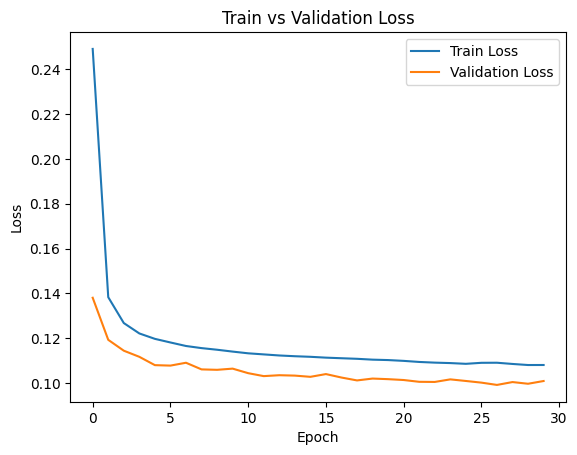

In [15]:
# Graficar las pérdidas
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

### Guardar los resultados 

In [16]:
results_exp1 = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_rmses': val_rmses
}

In [17]:
#Guardar el modelo entrenado
torch.save(model.state_dict(), "C://Users//Public//Downloads//saved_models//modelo_aurora_experimento_1_final.pth")


# **Resultados Obtenidos**

A continuación se listan de forma resumida las métricas de cada época (mostradas en el log):

| Época | Train Loss  | Validation Loss | Validation RMSE |
|-------|------------:|----------------:|----------------:|
| 1     |   0.249051  |       0.138073  |       0.199066  |
| 2     |   0.138326  |       0.119309  |       0.162321  |
| 3     |   0.126793  |       0.114462  |       0.149220  |
| 4     |   0.122155  |       0.111730  |       0.142119  |
| 5     |   0.119743  |       0.108018  |       0.135810  |
| 6     |   0.118129  |       0.107815  |       0.134151  |
| 7     |   0.116559  |       0.109088  |       0.134344  |
| 8     |   0.115617  |       0.106124  |       0.130800  |
| 9     |   0.114890  |       0.105934  |       0.130209  |
| 10    |   0.114062  |       0.106464  |       0.130350  |
| 11    |   0.113295  |       0.104437  |       0.127852  |
| 12    |   0.112811  |       0.103123  |       0.126179  |
| 13    |   0.112331  |       0.103526  |       0.126279  |
| 14    |   0.111996  |       0.103353  |       0.125815  |
| 15    |   0.111738  |       0.102807  |       0.125055  |
| 16    |   0.111363  |       0.104035  |       0.126291  |
| 17    |   0.111100  |       0.102490  |       0.124696  |
| 18    |   0.110845  |       0.101204  |       0.123314  |
| 19    |   0.110467  |       0.102032  |       0.124099  |
| 20    |   0.110282  |       0.101766  |       0.123774  |
| 21    |   0.109923  |       0.101385  |       0.123215  |
| 22    |   0.109442  |       0.100587  |       0.122371  |
| 23    |   0.109137  |       0.100527  |       0.122323  |
| 24    |   0.108940  |       0.101674  |       0.123338  |
| 25    |   0.108608  |       0.100959  |       0.122457  |
| 26    |   0.109059  |       0.100218  |       0.122707  |
| 27    |   0.109094  |       0.099198  |       0.121436  |
| 28    |   0.108549  |       0.100472  |       0.122350  |
| 29    |   0.108074  |       0.099719  |       0.121767  |
| 30    |   0.108083  |       0.100940  |       0.122759  |

Podemos observar:

- **Train Loss** desciende desde ~0.249 hasta ~0.108, representando una mejora significativa en el ajuste del modelo sobre el conjunto de entrenamiento.  
- **Validation Loss** comienza alrededor de 0.138 y baja hasta ~0.100–0.101, señal de convergencia y buena generalización.  
- **Validation RMSE** sigue un patrón similar, descendiendo de 0.20 a 0.12–0.13, confirmando una disminución consistente del error medio cuadrático.

La **diferencia** entre las pérdidas de entrenamiento y validación se mantiene pequeña, lo que sugiere que no hubo un sobreajuste excesivo con este conjunto de parámetros (batch_size=8, LR=1e-5, 30 épocas).

---

# **Visualización de las Pérdidas**

En la figura generada (Train vs. Validation Loss), se aprecia cómo ambas curvas descienden relativamente en paralelo. Este comportamiento indica que el modelo no memoriza únicamente los datos de entrenamiento, sino que **generaliza** bien a la validación.

---

# **Conclusión**

Con un *learning rate* bajo (`1e-5`) y un tamaño de batch de 8:

1. **El modelo Aurora** consigue reducir la *Train Loss* de 0.249 a ~0.108,  
2. **La Validación Loss** baja desde 0.138 a ~0.101,  
3. **El RMSE** de validación pasa de 0.20 a ~0.12–0.13.

Estos resultados demuestran un **buen ajuste** y **ausencia de sobreajuste notorio**. El **tiempo de entrenamiento** es notable (varias horas) por el tamaño del dataset y la complejidad del modelo; sin embargo, los logros en las métricas indican que la configuración (batch_size, LR, etc.) es adecuada para entrenar Aurora en este volumen de datos.
